# **Chapter 5. 머신러닝(Machine Learning) 기초** 





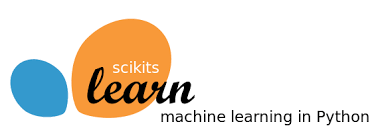


---
### **학습 목표**
> 5-1. 머신 러닝 개요 <br>
> 5-2. sklearn 이란? <br>
> 5-3. 전처리 기본 (정규화, 표준화, 범주형 데이터, 학습/테스트 세트 분할) <br>
> 5-4. 분류 분석 모델링 <br>
> 5-5. 분류 성능 평가하기 <br>
> 5-6. 회귀 분석 모델링 <br>
> 5-7. 회귀 성능 평가하기 <br>
> 5-8. 앙상블 모델링 <br>
> **5-9. 하이퍼파라미터(hyper-parameter) 튜닝** <br>
> 5-10. 비지도 군집화 분석

## 5-9. 하이퍼 파라미터 (hyper-parameter) 튜닝
> #### 하이퍼 파라미터 튜닝이란?
> - 머신 러닝에서 하이퍼 파라미터란 **사용자가 학습 모델에 설정 가능한 옵션**이라고 볼 수 있습니다.
> - 모든 데이터와 문제에서 가장 좋은 하이퍼 파라미터가 정해져 있으면 좋겠지만, 
> - **데이터의 성격, 종류**에 따라 적절한 **하이퍼 파라미터는 모두 다릅니다.**
> - 수동으로 적절한 하이퍼 파라미터를 찾는 작업은 매우 지루하고 시간이 오래걸립니다.
> - scikit-learn 에서는 다음 두가지 방법의 자동화 탐색 기능을 제공합니다.
    - **GridSearchCV (그리드 탐색)**
    - **RandomizedSearchCV (랜덤 탐색)** : 


In [53]:
# 라이브러리 불러오기
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [54]:
## 이전 강의에서 다룬 내용 (전처리, 모델 학습, 예측)
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split    # 라이브러리 로딩
from lightgbm import LGBMRegressor  # 분류 문제 : LGBMClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

dataset = fetch_california_housing()
cal_house_df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
cal_house_df['Price($)'] = dataset.target * 100000

X = cal_house_df.drop('Price($)', axis=1)  # 예측에 사용할 변수 
Y = cal_house_df['Price($)']               # 예측할 변수

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.01, shuffle=True)

# LGBM 모델 정의 / 학습
lgbm_model = LGBMRegressor()
lgbm_model.fit(X_train, Y_train)

# 예측 결과 확인
predictions = lgbm_model.predict(X_test)
mae = mean_absolute_error(Y_test, predictions)
mse = mean_squared_error(Y_test, predictions)
rmse = mse ** 0.5
r2 = r2_score(Y_test, predictions)
adj_r2 = 1 - ( 1 - r2 ) * ( len(Y_test) - 1 ) / ( len(Y_test) - X_test.shape[1] - 1 )


print("MAE: {}".format(round(mae, 2)))
print("MSE: {}".format(round(mse, 2)))
print("RMSE: {}".format(round(rmse), 2))
print("R2: {}".format(round(r2, 2)))
print("adj_R2: {}".format(round(adj_r2, 2)))

MAE: 30199.68
MSE: 2035575185.04
RMSE: 45117
R2: 0.84
adj_R2: 0.83


> ###  **5-9-1. GridSearchCV**
> -  GridSearchCV 방식은 **사전에 지정된 하이퍼파라미터 값**들을 **그리드 (격자) 형식**으로 **모두 탐색**하면서 최적 성능 조합을 만들어 줍니다.
> - 사용 방법
    - **`GridSearchCV(모델명, 하이퍼파라미터 그리드(dict), cv=성능 비교할 분할 데이터 수, scoring=평가 방법)`**

[LightGBM 공식문서](https://lightgbm.readthedocs.io/en/latest/Parameters.html) <br>
- 핵심 파라미터
    - **`learning_rate`** : 학습률 (틀린 값에 대한 가중치를 얼마나 줄 것인지)
    - **`num_leaves`** : 전체 나무의 잎(leave) 수
    - **`min_child_samples`** : 나뭇잎에 계산되는 최소 데이터 수
    - **`n_estimators`** : 부스팅(학습 반복) 횟수

In [55]:
# 하이퍼 파라미터 목록
lgbm_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [65]:
# 튜닝할 하이퍼 파라미터 목록 만들기
param_grid = {'learning_rate ': [0.05, 0.1],
              'num_leaves' : [31, 50],
              'min_child_samples' : [50],
              'n_estimators': [100, 300]}

In [66]:
# 라이브러리 로딩
from sklearn.model_selection import GridSearchCV

In [67]:
# 그리드 탐색 실행
grid_search = GridSearchCV(lgbm_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'learning_rate ': [0.05, 0.1],
                         'min_child_samples': [50], 'n_estimators': [100, 300],
                         'num_leaves': [31, 50]},
             scoring='neg_mean_squared_error')

In [68]:
# 최적 파라미터 확인
grid_search.best_params_

{'learning_rate ': 0.05,
 'min_child_samples': 50,
 'n_estimators': 300,
 'num_leaves': 50}

In [69]:
# 최적 파라미터로 성능 확인
lgbm_model_gridCV = LGBMRegressor(learning_rate=0.05, min_child_samples=50,  n_estimators=300, num_leaves=50)
lgbm_model_gridCV.fit(X_train, Y_train)

# 예측 결과 확인
predictions = lgbm_model_gridCV.predict(X_test)
mae = mean_absolute_error(Y_test, predictions)
mse = mean_squared_error(Y_test, predictions)
rmse = mse ** 0.5
r2 = r2_score(Y_test, predictions)
adj_r2 = 1 - ( 1 - r2 ) * ( len(Y_test) - 1 ) / ( len(Y_test) - X_test.shape[1] - 1 )

print("MAE: {}".format(round(mae, 2)))
print("MSE: {}".format(round(mse, 2)))
print("RMSE: {}".format(round(rmse), 2))
print("R2: {}".format(round(r2, 2)))
print("adj_R2: {}".format(round(adj_r2, 2)))

MAE: 27801.16
MSE: 1751954011.33
RMSE: 41856
R2: 0.86
adj_R2: 0.85


> ###  **5-9-2. RandomizedSearchCV**
> - **GridSearchCV 방식**은 **비교적 적은 수의 조합을 탐색할 때 좋습니다.** 하지만 하이퍼 파라미터 공간이 커지면 이전 방식은 모든 조합을 탐색하기 때문에, 너무 오래 걸리는 단점이 있습니다.
> - 이 때, RandomizedSearchCV 가 좋은 대안이 될 수 있습니다. 임의의 하이퍼 파라미터를 탐색하지만, **지정된 횟수만큼 탐색을 실행하기 때문에 연산량을 조절**할 수 있습니다.
> - 사용 방법
    - **`RandomizedSearchCV(모델명, 하이퍼파라미터 범위(dict), n_iter=탐색 횟수, cv=성능 비교할 분할 데이터 수, scoring=평가 방법)`**


In [73]:
# 튜닝할 하이퍼 파라미터 목록 만들기
param_range = {'learning_rate ': [0.05, 0.1],
               'num_leaves' : [31, 50],
               'min_child_samples' : [50],
               'n_estimators': [100, 300]}

In [74]:
# 라이브러리 로딩
from sklearn.model_selection import RandomizedSearchCV

In [76]:
# 그리드 탐색 실행
random_search = RandomizedSearchCV(lgbm_model, param_range, n_iter=5, cv=5, scoring='neg_mean_squared_error')
random_search.fit(X_train, Y_train)

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(), n_iter=5,
                   param_distributions={'learning_rate ': [0.05, 0.1],
                                        'min_child_samples': [50],
                                        'n_estimators': [100, 300],
                                        'num_leaves': [31, 50]},
                   scoring='neg_mean_squared_error')

In [77]:
# 최적 파라미터 확인
random_search.best_params_

{'learning_rate ': 0.1,
 'min_child_samples': 50,
 'n_estimators': 300,
 'num_leaves': 50}

In [78]:
# 최적 파라미터로 성능 확인
lgbm_model_randomCV = LGBMRegressor(learning_rate=0.1, min_child_samples=50,  n_estimators=300, num_leaves=50)
lgbm_model_randomCV.fit(X_train, Y_train)

# 예측 결과 확인
predictions = lgbm_model_randomCV.predict(X_test)
mae = mean_absolute_error(Y_test, predictions)
mse = mean_squared_error(Y_test, predictions)
rmse = mse ** 0.5
r2 = r2_score(Y_test, predictions)
adj_r2 = 1 - ( 1 - r2 ) * ( len(Y_test) - 1 ) / ( len(Y_test) - X_test.shape[1] - 1 )

print("MAE: {}".format(round(mae, 2)))
print("MSE: {}".format(round(mse, 2)))
print("RMSE: {}".format(round(rmse), 2))
print("R2: {}".format(round(r2, 2)))
print("adj_R2: {}".format(round(adj_r2, 2)))

MAE: 27062.73
MSE: 1611276169.09
RMSE: 40141
R2: 0.87
adj_R2: 0.86


> **하이퍼 파라미터 튜닝 결과 비교**

In [80]:
# 모델 별 성능 집계
mae, mse, rmse, r2,  adj_r2 = [], [], [], [], []

In [81]:
for model in [lgbm_model, lgbm_model_gridCV, lgbm_model_randomCV]:
    predictions = model.predict(X_test)
    mae.append(mean_absolute_error(Y_test, predictions))
    mse.append(mean_squared_error(Y_test, predictions))
    rmse.append(mse[-1])
    r2.append(r2_score(Y_test, predictions))
    adj_r2.append(1 - ( 1 - r2[-1] ) * ( len(Y_test) - 1 ) / ( len(Y_test) - X_test.shape[1] - 1 ))

perf_df = pd.DataFrame({'model':['Default', 'GridSearchCV', 'RandomSearchCV'],
                        'MAE':mae,
                        'MSE':mse,
                        'RMSE':rmse,
                        'R2':r2,
                        'adj_R2':adj_r2})

Text(0.5, 1.0, 'R2')

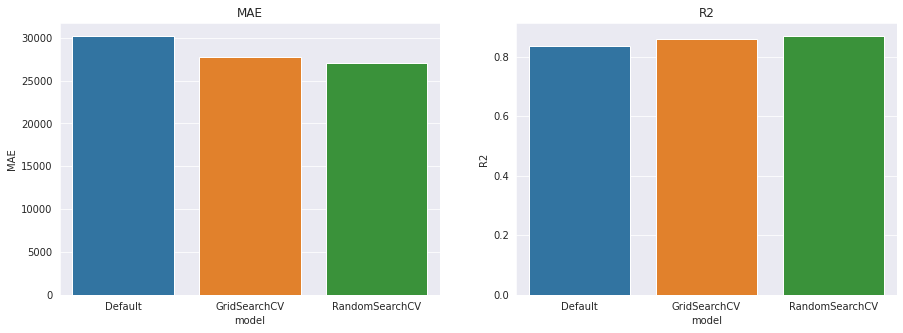

In [82]:
# 하이퍼 파라미터 튜닝 모델 성능 시각화
sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(15,5))

# MAE
sns.barplot(data=perf_df, x="model", y="MAE", ax = axes[0])
axes[0].set_title("MAE")
# R2
sns.barplot(data=perf_df, x="model", y="R2", ax = axes[1])
axes[1].set_title("R2")